# Chargement des données

In [0]:
# On importe les librairies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler


In [2]:
#On importe le dataset global en précisant qu'il s'agit de time series (squeeze = True)

df = pd.read_csv('https://raw.githubusercontent.com/ghassenabdedayem/AltCoins/master/data_sources/df_global_final.csv',
                 sep = ',', 
                 parse_dates=[0], 
                 index_col=0, 
                 squeeze=True)
df.head()

,GOLD_USD_AM,GOLD_USD_PM,GOLD_GBP_AM,GOLD_GBP_PM,GOLD_EUR_AM,GOLD_EUR_PM,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BTC_Market_Cap,BTC_Intraday,ADA_Open,ADA_High,ADA_Low,ADA_Close,ADA_Volume,ADA_Market_Cap,ADA_Intraday,LTC_Open,LTC_High,LTC_Low,LTC_Close,LTC_Volume,LTC_Market_Cap,LTC_Intraday,EOS_Open,EOS_High,EOS_Low,EOS_Close,EOS_Volume,EOS_Market_Cap,EOS_Intraday,ETH_Open,ETH_High,ETH_Low,ETH_Close,ETH_Volume,ETH_Market_Cap,...,IEF_Low,IEF_Close,IEF_Volume,NVIDIA_Open,NVIDIA_High,NVIDIA_Low,NVIDIA_Close,NVIDIA_Volume,AMD_Open,AMD_High,AMD_Low,AMD_Close,AMD_Volume,GOOGLE_Open,GOOGLE_High,GOOGLE_Low,GOOGLE_Close,GOOGLE_Volume,GPS_Open,GPS_High,GPS_Low,GPS_Close,GPS_Volume,COCOA_Open,COCOA_High,COCOA_Low,COCOA_Close,COCOA_Volume,IBM_Open,IBM_High,IBM_Low,IBM_Close,IBM_Volume,GGTrends_values,Day_Cos,Day_Sin,Month_Cos,Month_Sin,Quarter_Cos,Quarter_Sin
GOLD_Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-11-30,1456.0,1460.0,1129.55,1131.32,1323.24,1327.42,7764,7836,7515,7569,17158194786,136829391049,321,0.041416,0.042268,0.040068,0.040425,64184926,1048107282,0.002200,48.91,49.28,47.09,47.48,2678481167,3026175357,2.19,2.80,2.83,2.74,2.76,1537950803,2598670742,0.09,155,156,151,152,6565950868,16589132426,...,111.660,111.66,0.0,216.53,216.53,216.53,216.53,0.0,39.16,39.16,39.160,39.16,0.0,1304.98,1304.980,1304.98,1304.98,0.0,16.61,16.610,16.610,16.61,0.0,2512.405,2512.405,2512.405,2512.405,0.0,134.45,134.45,134.45,134.45,0.0,8.928571,0.623490,-0.781831,0.866025,-0.5,1.0,-2.449294e-16
2019-11-29,1456.0,1460.0,1129.55,1131.32,1323.24,1327.42,7466,7781,7460,7761,19709695456,140280108521,321,0.039227,0.042040,0.039194,0.041423,99506198,1073986624,0.002846,47.09,49.32,47.09,48.88,2944492393,3115330867,2.23,2.64,2.80,2.64,2.80,1899935358,2636173142,0.16,151,156,151,155,7503898278,16887922522,...,111.440,111.66,1798695.0,217.00,218.14,215.78,216.53,1881106.0,39.07,39.51,39.020,39.16,7526362.0,1305.50,1310.205,1303.97,1304.98,392185.0,16.91,16.930,16.570,16.61,1311527.0,2512.405,2512.405,2512.405,2512.405,0.0,133.59,134.51,133.04,134.45,773921.0,9.464286,-0.222521,-0.974928,0.866025,-0.5,1.0,-2.449294e-16
2019-11-28,1458.0,1455.0,1127.27,1127.35,1323.60,1321.84,7536,7730,7454,7463,19050116751,134879411013,276,0.039129,0.039990,0.038641,0.039190,60743403,1016079672,0.001349,48.00,48.55,47.02,47.06,2662459127,2998875250,1.53,2.69,2.76,2.62,2.64,1514999632,2483560320,0.14,153,156,151,151,7346531960,16496129470,...,111.660,111.66,0.0,218.24,218.24,218.24,218.24,0.0,39.41,39.41,39.410,39.41,0.0,1312.99,1312.990,1312.99,1312.99,0.0,16.91,16.910,16.910,16.91,0.0,2512.405,2512.405,2512.405,2512.405,0.0,133.76,133.76,133.76,133.76,0.0,10.714286,-0.900969,-0.433884,0.866025,-0.5,1.0,-2.449294e-16
2019-11-27,1459.8,1454.0,1134.12,1129.74,1326.23,1322.30,7220,7619,6974,7531,23991412764,136102712894,645,0.036955,0.039800,0.035783,0.039049,76841561,1012420887,0.004017,47.16,48.52,45.44,48.01,2979663352,3059223170,3.08,2.63,2.73,2.53,2.69,2247567344,2532133843,0.20,148,154,143,153,8778095308,16634910472,...,111.605,111.66,2334424.0,218.67,220.02,217.18,218.24,5314571.0,39.50,39.76,39.080,39.41,33127997.0,1315.00,1318.187,1309.63,1312.99,989345.0,17.01,17.150,16.710,16.91,0.0,2512.405,2512.405,2512.405,2512.405,0.0,135.28,135.70,133.63,133.76,0.0,11.428571,-0.900969,0.433884,0.866025,-0.5,1.0,-2.449294e-16
2019-11-26,1458.0,1455.0,1133.76,1131.86,1322.96,1321.11,7145,7320,7098,7218,21129505542,130429018720,222,0.036046,0.037074,0.035705,0.036993,57431470,959117573,0.001369,45.81,47.54,45.66,47.27,2659405400,3012041642,1.88,2.53,2.65,2.53,2.63,1894353525,2479535254,0.12,146,150,145,148,7648516297,16193326033,...,111.850,111.95,3578750.0,220.50,220.69,216.75,217.00,9487105.0,38.99,39.48,38.815,38.99,42706750.0,1309.86,1314.760,1305.09,1313.55,1011135.0,17.11,17.265,16.855,17.01,0.0,2512.405,2512.405,2512.405,2512.405,0.0,136.01,136.15,134.77,135.03,0.0,11.785714,-0.222521,0.974928,0.866025,-0.5,1.0,-2.449294e-16


# Exploration des données

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


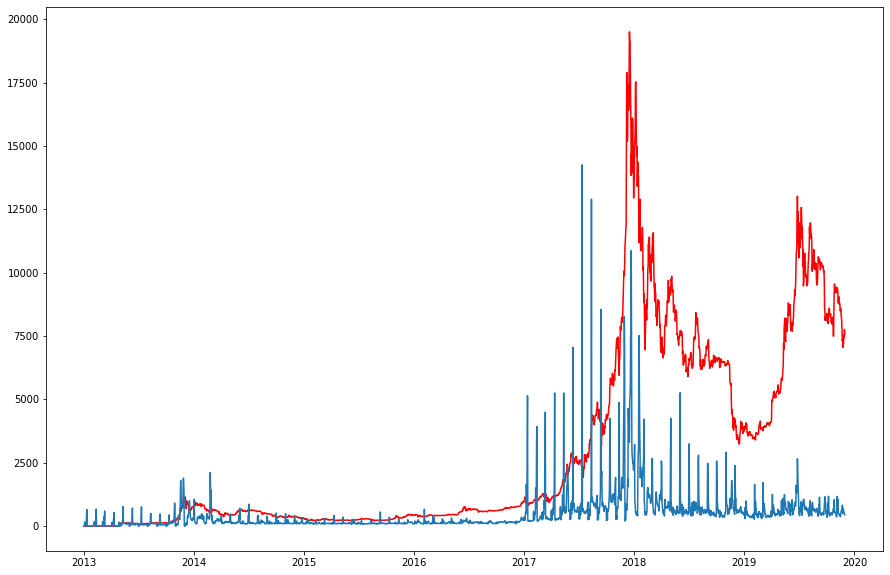

In [0]:
# On affiche Google Trends et le cours du Bitcoin BTC_Close sur le même graphique

plt.figure(figsize=(15,10))
plt.plot(df.BTC_Close, color='r')
plt.plot(df.GGTrends_values*50)
plt.show()

In [0]:
# On affiche les corrélations les plus grandes en valeur absolues

df.corr()['BTC_Close'].sort_values(ascending=True)[:20]
# On constate la grande corrélation entre les différents Altcoins et les recherches Google avec le BTC_Close

ICE_Close       -0.660399
ICE_High        -0.660199
ICE_Low         -0.659935
ICE_Open        -0.659837
CNYUSD_Low      -0.519462
CNYUSD_Open     -0.518139
CNYUSD_Close    -0.517418
CNYUSD_High     -0.517044
IBM_Close       -0.491645
IBM_High        -0.491559
IBM_Low         -0.490308
IBM_Open        -0.484886
GPS_Low         -0.427402
GPS_Close       -0.426486
GPS_Open        -0.426060
GPS_High        -0.424504
IBM_Volume      -0.405275
GPS_Volume      -0.380256
ICE_Volume      -0.355073
GOOGLE_Volume   -0.251581
Name: BTC_Close, dtype: float64

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


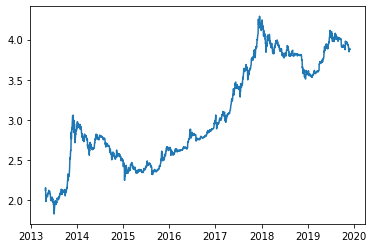

In [0]:
# On affiche le log10 du BTC_Close pour explorer les données
plt.plot(np.log10(df.BTC_Close))

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


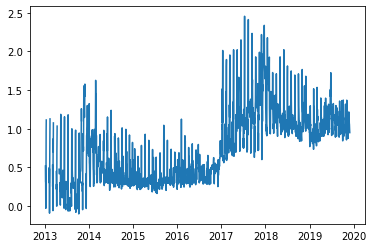

In [0]:
# On affiche également le log10 de Google Trends
plt.plot(np.log10(df.GGTrends_values))

# Préparation des données (Preprocessing)

In [3]:
# On charge à nouveau le fichier dans un DataFrame en précisant qu'il s'agit d'un TimeSeries de la colonne 0. On ne définit pas d'Index.
df_in = pd.read_csv('https://raw.githubusercontent.com/ghassenabdedayem/AltCoins/master/data_sources/df_global_final.csv',
                 sep = ',', 
                 parse_dates=[0], 
                 squeeze=True)
df_in.head(1)

,GOLD_Time,GOLD_USD_AM,GOLD_USD_PM,GOLD_GBP_AM,GOLD_GBP_PM,GOLD_EUR_AM,GOLD_EUR_PM,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BTC_Market_Cap,BTC_Intraday,ADA_Open,ADA_High,ADA_Low,ADA_Close,ADA_Volume,ADA_Market_Cap,ADA_Intraday,LTC_Open,LTC_High,LTC_Low,LTC_Close,LTC_Volume,LTC_Market_Cap,LTC_Intraday,EOS_Open,EOS_High,EOS_Low,EOS_Close,EOS_Volume,EOS_Market_Cap,EOS_Intraday,ETH_Open,ETH_High,ETH_Low,ETH_Close,ETH_Volume,...,IEF_Low,IEF_Close,IEF_Volume,NVIDIA_Open,NVIDIA_High,NVIDIA_Low,NVIDIA_Close,NVIDIA_Volume,AMD_Open,AMD_High,AMD_Low,AMD_Close,AMD_Volume,GOOGLE_Open,GOOGLE_High,GOOGLE_Low,GOOGLE_Close,GOOGLE_Volume,GPS_Open,GPS_High,GPS_Low,GPS_Close,GPS_Volume,COCOA_Open,COCOA_High,COCOA_Low,COCOA_Close,COCOA_Volume,IBM_Open,IBM_High,IBM_Low,IBM_Close,IBM_Volume,GGTrends_values,Day_Cos,Day_Sin,Month_Cos,Month_Sin,Quarter_Cos,Quarter_Sin
0,2019-11-30,1456.0,1460.0,1129.55,1131.32,1323.24,1327.42,7764,7836,7515,7569,17158194786,136829391049,321,0.041416,0.042268,0.040068,0.040425,64184926,1048107282,0.0022,48.91,49.28,47.09,47.48,2678481167,3026175357,2.19,2.8,2.83,2.74,2.76,1537950803,2598670742,0.09,155,156,151,152,6565950868,...,111.66,111.66,0.0,216.53,216.53,216.53,216.53,0.0,39.16,39.16,39.16,39.16,0.0,1304.98,1304.98,1304.98,1304.98,0.0,16.61,16.61,16.61,16.61,0.0,2512.405,2512.405,2512.405,2512.405,0.0,134.45,134.45,134.45,134.45,0.0,8.928571,0.62349,-0.781831,0.866025,-0.5,1.0,-2.449294e-16


In [0]:
# On remplace les NaN par 0
df_out = df_in.ffill()

In [0]:
df_out.rename(columns={'GOLD_Time' : 'Date'}, inplace=True)
df_out.set_index('Date', inplace=True)

In [0]:
target=df_out.BTC_Close
# days = ['Day_Cos',	'Day_Sin',	'Month_Cos',	'Month_Sin',	'Quarter_Cos',	'Quarter_Sin']


target=target[:-1]  #Retirer la première valeur
target = pd.array(target)

features=df_out.drop(['BTC_Close'],axis=1)
features=features[1:]  #Retirer la dernières ligne

In [30]:
len(df_out)

2529

In [0]:
df_out = features
df_out['BTC_Close'] = target


In [0]:
# On définit une fonction qui normalise les données explicatives sauf les colonnes relatives aux dates (excluded)

def min_max_scaler(df, excluded=[]):
  transformed_data = pd.DataFrame()
  df_saved = df

  excluded.extend(['Day_Cos',	'Day_Sin',	'Month_Cos',	'Month_Sin',	'Quarter_Cos',	'Quarter_Sin'])

  df_dropped = df.drop(excluded, axis=1)
  df_scaled = (df_dropped - df_dropped.min()) / (df_dropped.max() - df_dropped.min())

  # df_dropped_array = np.array(df_dropped)
  # transformed_data = pd.DataFrame(scaler.fit_transform(df_dropped_array), columns=df_dropped.columns, index=df.Date)

  for col in excluded:
    df_scaled[col] = df_saved[col]

  return df_scaled

In [55]:
#On définit la liste des colonnes à ne pas scaler, puis on scale les données avec la fonction
excluded = []
scaled_data = min_max_scaler(df_out, excluded)

scaled_data.head()

,GOLD_USD_AM,GOLD_USD_PM,GOLD_GBP_AM,GOLD_GBP_PM,GOLD_EUR_AM,GOLD_EUR_PM,BTC_Open,BTC_High,BTC_Low,BTC_Volume,BTC_Market_Cap,BTC_Intraday,ADA_Open,ADA_High,ADA_Low,ADA_Close,ADA_Volume,ADA_Market_Cap,ADA_Intraday,LTC_Open,LTC_High,LTC_Low,LTC_Close,LTC_Volume,LTC_Market_Cap,LTC_Intraday,EOS_Open,EOS_High,EOS_Low,EOS_Close,EOS_Volume,EOS_Market_Cap,EOS_Intraday,ETH_Open,ETH_High,ETH_Low,ETH_Close,ETH_Volume,ETH_Market_Cap,ETH_Intraday,...,IEF_Close,IEF_Volume,NVIDIA_Open,NVIDIA_High,NVIDIA_Low,NVIDIA_Close,NVIDIA_Volume,AMD_Open,AMD_High,AMD_Low,AMD_Close,AMD_Volume,GOOGLE_Open,GOOGLE_High,GOOGLE_Low,GOOGLE_Close,GOOGLE_Volume,GPS_Open,GPS_High,GPS_Low,GPS_Close,GPS_Volume,COCOA_Open,COCOA_High,COCOA_Low,COCOA_Close,COCOA_Volume,IBM_Open,IBM_High,IBM_Low,IBM_Close,IBM_Volume,GGTrends_values,BTC_Close,Day_Cos,Day_Sin,Month_Cos,Month_Sin,Quarter_Cos,Quarter_Sin
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-11-29,0.631563,0.636984,0.745728,0.757403,0.854055,0.856007,0.383363,0.387326,0.393170,0.436967,0.429645,0.078102,0.033527,0.031609,0.037687,0.037318,0.058063,0.037180,0.008214,0.131122,0.131418,0.140287,0.136407,0.422957,0.159903,0.016790,0.121996,0.122324,0.139831,0.129991,0.352170,0.148354,0.030948,0.108089,0.108939,0.117054,0.111032,0.402107,0.124725,0.011990,...,0.821748,0.096963,0.739256,0.734115,0.741831,0.737436,0.020427,0.188779,0.943170,0.181995,0.946307,0.023381,0.967551,0.951155,0.959170,0.959687,0.017013,0.045966,0.038727,0.046379,0.040026,0.039736,0.59827,0.58568,0.603487,0.597849,0.0,0.591915,0.247990,0.248607,0.247665,0.033098,0.033208,0.388214,-0.222521,-0.974928,0.866025,-0.5,1.0,-2.449294e-16
2019-11-28,0.634678,0.629227,0.741824,0.750828,0.854736,0.845496,0.386958,0.384788,0.392853,0.422344,0.413104,0.067153,0.033444,0.030068,0.037155,0.035306,0.035444,0.035176,0.003893,0.133656,0.129367,0.140078,0.131328,0.382445,0.153926,0.011519,0.124307,0.120577,0.138771,0.122563,0.280819,0.139766,0.027079,0.109520,0.108939,0.117054,0.108166,0.393674,0.121832,0.011990,...,0.821748,0.000000,0.743727,0.734471,0.750782,0.743601,0.000000,0.190493,0.940678,0.183892,0.952609,0.000000,0.973399,0.953922,0.968221,0.967752,0.000000,0.045966,0.038085,0.057179,0.049632,0.000000,0.59827,0.58568,0.603487,0.597849,0.0,0.592765,0.241061,0.255215,0.241284,0.000000,0.037594,0.398061,-0.900969,-0.433884,0.866025,-0.5,1.0,-2.449294e-16
2019-11-27,0.637482,0.627676,0.753553,0.754786,0.859714,0.846363,0.370732,0.379262,0.367556,0.531893,0.416850,0.156934,0.031585,0.029925,0.034407,0.035179,0.044838,0.035049,0.011593,0.131317,0.129287,0.135371,0.133979,0.428009,0.157023,0.023189,0.121534,0.119266,0.134004,0.124884,0.416607,0.142499,0.038685,0.105941,0.107542,0.110853,0.109599,0.470386,0.122857,0.026379,...,0.821748,0.125843,0.745277,0.740815,0.746925,0.743601,0.057710,0.190947,0.949402,0.182287,0.952609,0.102915,0.974969,0.959085,0.964849,0.967752,0.042919,0.049180,0.045798,0.050826,0.049632,0.000000,0.59827,0.58568,0.603487,0.597849,0.0,0.600360,0.258985,0.254022,0.241284,0.000000,0.040100,0.382777,-0.900969,0.433884,0.866025,-0.5,1.0,-2.449294e-16
2019-11-26,0.634678,0.629227,0.752936,0.758297,0.853525,0.844121,0.366881,0.364379,0.374091,0.468444,0.399473,0.054015,0.030809,0.027875,0.034332,0.033327,0.033512,0.033204,0.003951,0.127558,0.126675,0.136026,0.131914,0.382006,0.154601,0.014154,0.116913,0.115771,0.134004,0.122098,0.351136,0.139539,0.023211,0.104510,0.104749,0.112403,0.106017,0.409856,0.119596,0.011990,...,0.841707,0.192921,0.751875,0.743202,0.745361,0.739130,0.103020,0.188376,0.942423,0.180998,0.942022,0.132672,0.970955,0.955680,0.960293,0.968316,0.043864,0.052395,0.049494,0.055432,0.052834,0.000000,0.59827,0.58568,0.603487,0.597849,0.0,0.604007,0.263143,0.264483,0.253029,0.000000,0.041353,0.386265,-0.222521,0.974928,0.866025,-0.5,1.0,-2.449294e-16
2019-11-25,0.636236,0.634502,0.752337,0.756608,0.858011,0.848340,0.361438,0.364329,0.348740,0.946337,0.395442,0.170803,0.030379,0.027958,0.03

# X_train, y_train, X_test, y_test

In [0]:
def train_test_split(df, test_size):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[-split_row:]
    test_data = df.iloc[:-split_row]
    return train_data, test_data

In [0]:
def extract_window_data(df, window_len, decalage):
    window_data = []
    for idx in range(len(df) - window_len - decalage):
        tmp = df[(idx + decalage): (idx + window_len + decalage)].copy()
        window_data.append(tmp.values)
    return np.array(window_data)

In [0]:
def prepare_data(df, target_col, window_len, test_size, decalage):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, decalage)
    X_test = extract_window_data(test_data, window_len, decalage)
    y_train = train_data[target_col][(window_len + decalage):].values
    y_test = test_data[target_col][(window_len + decalage):].values


    return train_data, test_data, X_train, X_test, y_train, y_test

In [0]:
window_len = 1
decalage = 0
test_size = 0.05
target_col = 'BTC_Close'

In [0]:
train, test, X_train, X_test, y_train, y_test = prepare_data(scaled_data, target_col, window_len=window_len, test_size=test_size, decalage=decalage)

In [0]:
# On découpe les données en échantillon d'entrainement et échantillon de test. Ici on a choisit les time_window=100 dernières valeurs dans le temps comme échantillon de test.
# On peu aussi découper les données de façon aléatoire avec train_test_split si on veut.

# time_window = 100

# y_train = np.asarray(target)[time_window:]
# y_test = target[:time_window]
# X_train = np.asarray(scaled_data)[time_window:, :]
# X_test = np.asarray(scaled_data)[:time_window, :]

In [0]:
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

# Modèle de prédiction

In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM

In [0]:
def build_lstm_model(input_data, output_size, activ_func, neurons=100, 
                     dropout=0.15, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(lstm_neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=int(neurons/10), activation = activ_func))
    model.add(Dense(units=int(neurons/100), activation = activ_func))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [0]:
lstm_neurons = 516
activ_func = 'tanh'
epochs = 14
batch_size = 32
loss = 'mse'
dropout = 0.25
optimizer = 'adam'

In [0]:
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, activ_func=activ_func, dropout=dropout, loss=loss, optimizer=optimizer)


In [66]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/14
2402/2402 [==============================] - 5s 2ms/step - loss: 0.0098
Epoch 2/14
2402/2402 [==============================] - 4s 2ms/step - loss: 0.0011
Epoch 3/14
2402/2402 [==============================] - 4s 2ms/step - loss: 7.4592e-04
Epoch 4/14
2402/2402 [==============================] - 4s 2ms/step - loss: 5.3285e-04
Epoch 5/14
2402/2402 [==============================] - 4s 2ms/step - loss: 4.7078e-04
Epoch 6/14
2402/2402 [==============================] - 4s 1ms/step - loss: 4.1227e-04
Epoch 7/14
2402/2402 [==============================] - 4s 2ms/step - loss: 3.4297e-04
Epoch 8/14
2402/2402 [==============================] - 4s 2ms/step - loss: 4.2929e-04
Epoch 9/14
2402/2402 [==============================] - 4s 2ms/step - loss: 2.8875e-04
Epoch 10/14
2402/2402 [==============================] - 4s 2ms/step - loss: 2.6142e-04
Epoch 11/14
2402/2402 [==============================] - 4s 2ms/step - loss: 3.3840e-04
Epoch 12/14
2402/2402 [==========================

In [0]:
# On instancie le predicteur


In [0]:
# On l'entraine sur le set d'entrainement


In [0]:
# On prédit les valeurs pour l'échantillon de test (y_pred) et pour l'échantillon d'entrainement (y_train_pred)
y_pred_scaled = model.predict(X_test)
y_train_pred_scaled = model.predict(X_train)
y_train_pred = y_train_pred_scaled * (df_out.BTC_Close.max() - df_out.BTC_Close.min()) + df_out.BTC_Close.min()
y_pred = y_pred_scaled * (df_out.BTC_Close.max() - df_out.BTC_Close.min()) + df_out.BTC_Close.min()
y_train_unscaled = y_train * (df_out.BTC_Close.max() - df_out.BTC_Close.min()) + df_out.BTC_Close.min()
y_test_unscaled = y_test * (df_out.BTC_Close.max() - df_out.BTC_Close.min()) + df_out.BTC_Close.min()

# Evaluation des résultats

In [68]:
# On affiche la racine de l'erreur quadratique moyenne

print("La racine carrée de l'erreur quadratique moyenne sur les données d'entrainement : ", np.round(np.sqrt(mean_squared_error(y_train_pred, y_train_unscaled))))
print("La racine carrée de l'erreur quadratique moyenne sur les données de test : ", np.round(np.sqrt(mean_squared_error(y_pred, y_test_unscaled))))

La racine carrée de l'erreur quadratique moyenne sur les données d'entrainement :  287.0
La racine carrée de l'erreur quadratique moyenne sur les données de test :  684.0


In [69]:
# On crée un DataFrame qui contient les valeurs prédites et les valeurs réelles pour l'échantillon de test
df_result = pd.DataFrame(index=test[(window_len + decalage):].index)
df_result['BTC_Close_Reel'] = y_test_unscaled
df_result['BTC_Close_Pred'] = y_pred
df_result.head(10)

,BTC_Close_Reel,BTC_Close_Pred
Date,,
2019-11-28,7761.0,7344.314453
2019-11-27,7463.0,7183.959473
2019-11-26,7531.0,7296.649414
2019-11-25,7218.0,6962.403320
2019-11-24,7146.0,7066.533203
2019-11-23,7047.0,7262.118164
2019-11-22,7397.0,6287.938965
2019-11-21,7296.0,7379.407715
2019-11-20,7642.0,7450.278809


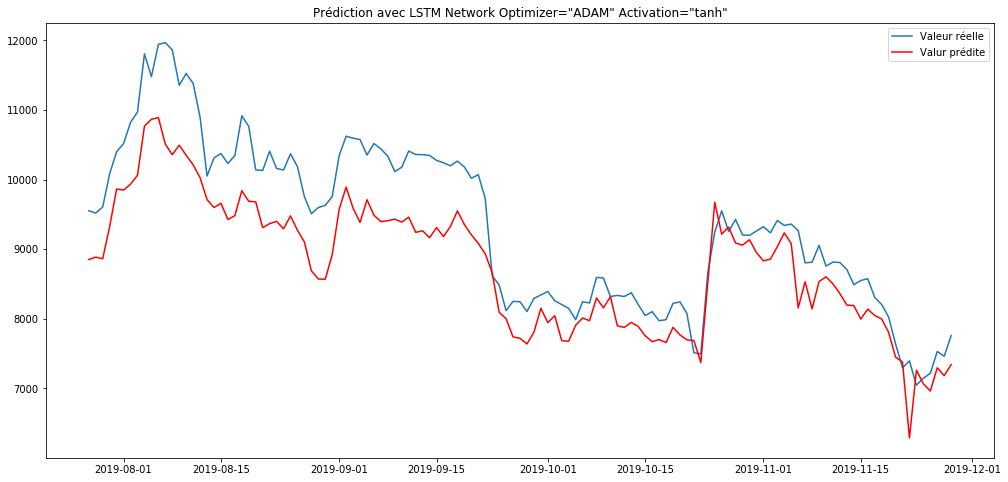

In [70]:
# On affiche les deux courbes pour comparer
plt.figure(figsize=(17, 8))
plt.plot(df_result.index, df_result['BTC_Close_Reel'], label='Valeur réelle')
plt.plot(df_result.index, df_result['BTC_Close_Pred'], color='r', label='Valur prédite')
plt.title('Prédiction avec LSTM Network Optimizer="ADAM" Activation="tanh"')
plt.legend()
plt.show()